In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# skopt
from skopt import BayesSearchCV

#helpers
import helpers

In [53]:
results = pd.DataFrame({'hiperparametry': [], 'wynik_zbior_1': [], 'wynik_zbior_2': [], 'wynik_zbior_3': [], 'wynik_zbior_4': [], 'model': []})

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [113]:
RANDOM_STATE = 123
RANDOM_STATES = [100, 200, 300, 400]

In [56]:
# Load datasets
import warnings
warnings.filterwarnings('ignore')

Xs = []
ys = []

df_1 = fetch_openml(data_id=31)
df_2 = fetch_openml(data_id=1489)
df_3 = fetch_openml(data_id=1558)
df_4 = fetch_openml(data_id=1053)

X_1 = df_1.data
y_1 = df_1.target
Xs.append(X_1)
ys.append(y_1)

X_2 = df_2.data
y_2 = df_2.target
Xs.append(X_2)
ys.append(y_2)

X_3 = df_3.data
y_3 = df_3.target
Xs.append(X_3)
ys.append(y_3)

X_4 = df_4.data
y_4 = df_4.target
Xs.append(X_4)
ys.append(y_4)

warnings.filterwarnings('default')

In [57]:
cols_num = []
cols_cat = []

for i in range(len(Xs)):
     numeric_features = Xs[i].select_dtypes(exclude=['category']).columns
     categorical_features = Xs[i].select_dtypes(include=['category']).columns

     cols_num.append(numeric_features)
     cols_cat.append(categorical_features)

In [58]:
# helper function to wrap model and do imputing and encoding

def getPipeline(model, num_cols, cat_cols):
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median"))]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy='most_frequent')),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols),
        ]
    )

    pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", model)]
    )

    return pipe

### Parameters grid

In [59]:
grid_log_reg = {
    'classifier__C': np.logspace(-4, 4, 400),
    'classifier__l1_ratio': np.linspace(0, 1, 400)
}

grid_tree = {
    'classifier__max_depth': np.concatenate(([None], range(5, 100, 1))),
    'classifier__min_samples_split': list(range(2, 20, 1)),
    'classifier__min_samples_leaf': list(range(2, 50, 1)),
    'classifier__max_leaf_nodes': np.concatenate(([None], range(30, 330, 1))),
    'classifier__ccp_alpha': np.logspace(-3, 3, 200)
}

grid_forest = {
    'classifier__max_depth': np.concatenate(([None], range(1, 20, 1))),
    'classifier__min_samples_split': list(range(2, 10)),
    'classifier__min_samples_leaf': list(range(2, 10, 1)),
    'classifier__max_leaf_nodes': np.concatenate(([None], range(2, 50, 1))),
    'classifier__ccp_alpha': np.logspace(-3, 2, 200),
    'classifier__bootstrap': [True, False],
    'classifier__warm_start': [True, False]
}

In [60]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

### Important helpers. They Return best CV scores and params for each set

In [80]:
def getRandomCVResults(model, grid, n_iter=10, n_jobs=1, verbose=0):
    search_res = []
    for i in range(len(Xs)):
        clf = getPipeline(model, cols_num[i], cols_cat[i])

        res = RandomizedSearchCV(clf, param_distributions=grid, random_state=RANDOM_STATE, cv=cv, scoring='accuracy', n_iter=n_iter, n_jobs=n_jobs, verbose=verbose)
        res.fit(Xs[i], ys[i])

        search_res.append(res)
        print(f"Fit for set number {i} is done")
        
    return search_res

def getBayesCVResults(model, grid, n_iter=10, n_jobs=1, verbose=0, n_points=1, random_states=[RANDOM_STATE, RANDOM_STATE, RANDOM_STATE, RANDOM_STATE]):
    search_res = []
    for i in range(len(Xs)):
        clf = getPipeline(model, cols_num[i], cols_cat[i])

        res = BayesSearchCV(clf, search_spaces=grid, cv=cv, scoring='accuracy', n_iter=n_iter, n_jobs=n_jobs, verbose=verbose, n_points=n_points, random_state=random_states[i])
        res.fit(Xs[i], ys[i])
        search_res.append(res)
        print(f"Fit for set number {i} is done")
    
    return search_res


# Logistic Regression

### Look for best hyperparams (Random search method) for each set

In [62]:
warnings.filterwarnings('ignore')

lr = LogisticRegression(penalty='elasticnet', solver='saga', random_state=RANDOM_STATE, max_iter=1000)
search_rand_lr = getRandomCVResults(lr, grid_log_reg, 5, -1)

warnings.filterwarnings('default')

Fit for set number 0 is done
Fit for set number 1 is done
Fit for set number 2 is done
Fit for set number 3 is done


In [63]:
res_lr = {
    'hiperparametry': search_rand_lr[0].cv_results_['params'], 
    'wynik_zbior_1': search_rand_lr[0].cv_results_['mean_test_score'], 
    'wynik_zbior_2': search_rand_lr[1].cv_results_['mean_test_score'], 
    'wynik_zbior_3': search_rand_lr[2].cv_results_['mean_test_score'], 
    'wynik_zbior_4': search_rand_lr[3].cv_results_['mean_test_score']
}

results_lr = pd.DataFrame(res_lr)
results_lr['model'] = 'LogisticRegression'
results_lr['mean_result'] = (results_lr['wynik_zbior_1'] + results_lr['wynik_zbior_2'] + results_lr['wynik_zbior_3'] + results_lr['wynik_zbior_4']) / 4

theta_lr = np.max(results_lr['mean_result'])

# Decision Tree

In [64]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
search_rand_tree = getRandomCVResults(tree, grid_tree, n_iter=5, n_jobs=-1)

Fit for set number 0 is done
Fit for set number 1 is done
Fit for set number 2 is done


C:\Users\macie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fit for set number 3 is done


In [65]:
res_tree = {
    'hiperparametry': search_rand_tree[0].cv_results_['params'], 
    'wynik_zbior_1': search_rand_tree[0].cv_results_['mean_test_score'], 
    'wynik_zbior_2': search_rand_tree[1].cv_results_['mean_test_score'], 
    'wynik_zbior_3': search_rand_tree[2].cv_results_['mean_test_score'], 
    'wynik_zbior_4': search_rand_tree[3].cv_results_['mean_test_score']
}

results_tree = pd.DataFrame(res_tree)
results_tree['model'] = 'DecisionTreeClassifier'
results_tree['mean_result'] = (results_tree['wynik_zbior_1'] + results_tree['wynik_zbior_2'] + results_tree['wynik_zbior_3'] + results_tree['wynik_zbior_4']) / 4

theta_tree = np.max(results_tree['mean_result'])

# Random Forest

In [66]:
forest = RandomForestClassifier(random_state=RANDOM_STATE)
search_rand_forest = getRandomCVResults(forest, grid_forest, n_iter=5, n_jobs=-1)

Fit for set number 0 is done
Fit for set number 1 is done
Fit for set number 2 is done


C:\Users\macie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Fit for set number 3 is done


In [67]:
res_forest = {
    'hiperparametry': search_rand_forest[0].cv_results_['params'], 
    'wynik_zbior_1': search_rand_forest[0].cv_results_['mean_test_score'], 
    'wynik_zbior_2': search_rand_forest[1].cv_results_['mean_test_score'], 
    'wynik_zbior_3': search_rand_forest[2].cv_results_['mean_test_score'], 
    'wynik_zbior_4': search_rand_forest[3].cv_results_['mean_test_score']
}

results_forest = pd.DataFrame(res_forest)
results_forest['model'] = 'RandomForestClassifier'
results_forest['mean_result'] = (results_forest['wynik_zbior_1'] + results_forest['wynik_zbior_2'] + results_forest['wynik_zbior_3'] + results_forest['wynik_zbior_4']) / 4

theta_forest = np.max(results_forest['mean_result'])

# BAYES !!!!!!!!!!!!!!!!!!!!!!!!!!

In [82]:
warnings.filterwarnings('ignore')

lr = LogisticRegression(penalty='elasticnet', solver='saga', random_state=RANDOM_STATE, max_iter=1000)
# give different random state each time to generate different start hyperParams to Bayes
search_bayes_lr = getBayesCVResults(lr, grid_log_reg, n_iter=5, n_jobs=-1, random_states=RANDOM_STATES)

warnings.filterwarnings('default')

Fit for set number 0 is done
Fit for set number 1 is done
Fit for set number 2 is done
Fit for set number 3 is done


In [83]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
# give different random state each time to generate different start hyperParams to Bayes
random_states = [100, 200, 300, 400]
search_bayes_tree = getBayesCVResults(tree, grid_tree, n_iter=5, n_jobs=-1, random_states=RANDOM_STATES)

Fit for set number 0 is done
Fit for set number 1 is done
Fit for set number 2 is done


C:\Users\macie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\macie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\macie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\macie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\macie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only

Fit for set number 3 is done


In [84]:
forest = RandomForestClassifier(random_state=RANDOM_STATE)
# give different random state each time to generate different start hyperParams to Bayes
search_bayes_forest = getBayesCVResults(forest, grid_forest, n_iter=5, n_jobs=-1, random_states=RANDOM_STATES)

Fit for set number 0 is done
Fit for set number 1 is done
Fit for set number 2 is done


C:\Users\macie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\macie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\macie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\macie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
C:\Users\macie\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only

Fit for set number 3 is done


In [85]:
res_bayes_lr = {
    'hiperparametry_zbior_1': search_bayes_lr[0].cv_results_['params'],
    'wynik_zbior_1': search_bayes_lr[0].cv_results_['mean_test_score'],

    'hiperparametry_zbior_2': search_bayes_lr[1].cv_results_['params'],
    'wynik_zbior_2': search_bayes_lr[1].cv_results_['mean_test_score'], 

    'hiperparametry_zbior_3': search_bayes_lr[2].cv_results_['params'],
    'wynik_zbior_3': search_bayes_lr[2].cv_results_['mean_test_score'], 

    'hiperparametry_zbior_4': search_rand_lr[3].cv_results_['params'],
    'wynik_zbior_4': search_bayes_lr[3].cv_results_['mean_test_score']
}

results_bayes_lr = pd.DataFrame(res_bayes_lr)
results_bayes_lr['model'] = 'LogisticRegression'

In [86]:
res_bayes_tree = {
    'hiperparametry_zbior_1': search_bayes_tree[0].cv_results_['params'],
    'wynik_zbior_1': search_bayes_tree[0].cv_results_['mean_test_score'],

    'hiperparametry_zbior_2': search_bayes_tree[1].cv_results_['params'],
    'wynik_zbior_2': search_bayes_tree[1].cv_results_['mean_test_score'], 

    'hiperparametry_zbior_3': search_bayes_tree[2].cv_results_['params'],
    'wynik_zbior_3': search_bayes_tree[2].cv_results_['mean_test_score'], 

    'hiperparametry_zbior_4': search_rand_tree[3].cv_results_['params'],
    'wynik_zbior_4': search_bayes_tree[3].cv_results_['mean_test_score']
}

results_bayes_tree = pd.DataFrame(res_bayes_tree)
results_bayes_tree['model'] = 'DecisionTreeClassifier'

In [87]:
res_bayes_forest = {
    'hiperparametry_zbior_1': search_bayes_forest[0].cv_results_['params'],
    'wynik_zbior_1': search_bayes_forest[0].cv_results_['mean_test_score'],

    'hiperparametry_zbior_2': search_bayes_forest[1].cv_results_['params'],
    'wynik_zbior_2': search_bayes_forest[1].cv_results_['mean_test_score'], 

    'hiperparametry_zbior_3': search_bayes_forest[2].cv_results_['params'],
    'wynik_zbior_3': search_bayes_forest[2].cv_results_['mean_test_score'], 

    'hiperparametry_zbior_4': search_rand_forest[3].cv_results_['params'],
    'wynik_zbior_4': search_bayes_forest[3].cv_results_['mean_test_score']
}

results_bayes_forest = pd.DataFrame(res_bayes_forest)
results_bayes_forest['model'] = 'RandomForestClassifier'

In [ ]:
# Mamy do dyspozycji
results_lr
results_tree
res_forest

theta_lr
theta_tree
theta_forest

results_bayes_lr
results_bayes_tree
results_bayes_forest

{'whiskers': [<matplotlib.lines.Line2D at 0x23eaaf0ffd0>,
 'caps': [<matplotlib.lines.Line2D at 0x23eaaf42d00>,
 'boxes': [<matplotlib.lines.Line2D at 0x23eab2aac10>,
 'medians': [<matplotlib.lines.Line2D at 0x23eab10a550>,
 'fliers': [<matplotlib.lines.Line2D at 0x23eaaf44d90>,
 'means': []}

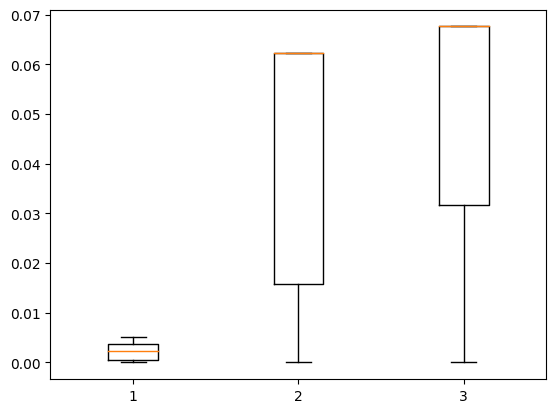

In [99]:
to_boxplot = [theta_lr - results_lr['mean_result'], theta_tree - results_tree['mean_result'], theta_forest - results_forest['mean_result']]

plt.boxplot(to_boxplot)

{'whiskers': [<matplotlib.lines.Line2D at 0x23eacfcda60>,
 'caps': [<matplotlib.lines.Line2D at 0x23eacfd91c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x23eacfcd6d0>],
 'medians': [<matplotlib.lines.Line2D at 0x23eacfd98e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x23eacfd9c70>],
 'means': []}

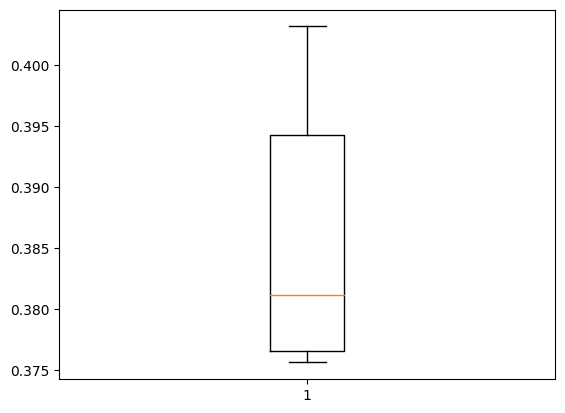

In [112]:
set_1_bayes_to_boxplot = [theta_forest - results_bayes_forest['wynik_zbior_1']]
plt.boxplot(theta_lr - results_bayes_lr['wynik_zbior_4'])